# Kernel based discrepancies

One definition of discrepancy starts with a symmetric, positive definite kernel, $K:[0,1]^d\times [0,1]^d \to \mathbb{R}$, i.e.,
\begin{gather*}
K(\boldsymbol{t},\boldsymbol{x}) = K(\boldsymbol{x},\boldsymbol{t}) \qquad \forall \boldsymbol{t}, \boldsymbol{x} \in [0,1]^d \\
\sum_{i,j = 1}^{n} c_i K(\boldsymbol{x}_i,\boldsymbol{x}_j ) \boldsymbol{c}_j > 0 \qquad \forall \boldsymbol{c} \ne \boldsymbol{0}, \ \boldsymbol{x}_1, \ldots, \boldsymbol{x}_n \text{ distinct and } \in [0,1]^d
\end{gather*}
The discrepancy, $D(\{\boldsymbol{x}\}_{i=1}^n)$ is defined in terms of the kernel as
$$
[D(\{\boldsymbol{x}_i\}_{i=1}^n,K)]^2= \int_{[0,1]^d} \int_{[0,1]^d} K(\boldsymbol{t},\boldsymbol{x}) \, \mathrm{d}\boldsymbol{t} \mathrm{d}\boldsymbol{x}
- \frac{2}{n} \sum_{i=1}^n \int_{[0,1]^d} K(\boldsymbol{t}, \boldsymbol{x}_i) \, \mathrm{d}\boldsymbol{t}
+ \frac{1}{n^2} \sum_{i,j = 1}^n K(\boldsymbol{x}_i, \boldsymbol{x}_j)
$$
The discrepancy requires $\mathcal{O}(dn^2)$ operations to compute, assuming one evaluation of the kernel requires $d$ operations to compute.

We can simplify the cost to compute the discrepancy for a randomly shifted Kronecker sequence:
$$
\begin{aligned}
\text{Kronecker: } \mathbb{E}\{[D(\{i\boldsymbol{\alpha} + \boldsymbol{\Delta} \bmod \boldsymbol{1}\}_{i=1}^n,K)]^2\}
& = - \int_{[0,1]^d} \widetilde{K}(\boldsymbol{t}) \, \mathrm{d}\boldsymbol{t} + \frac{1}{n^2} \sum_{i,j = 1}^n \int_{[0,1]^d} \widetilde{K}((i - j)\boldsymbol{\alpha} \bmod \boldsymbol{1}) \\
& =  - \int_{[0,1]^d} \widetilde{K}(\boldsymbol{t}) \, \mathrm{d}\boldsymbol{t} 
+ \frac 1{n^2} \sum_{k=1-n}^{n-1}  (n -  \lvert k \rvert)\widetilde{K}(k \boldsymbol{\alpha} \bmod \boldsymbol{1}) \\
& = - \int_{[0,1]^d} \widetilde{K}(\boldsymbol{t}) \, \mathrm{d}\boldsymbol{t}
+ \frac 1{n^2} \biggl[n \widetilde{K}(\boldsymbol{0}) +  2\sum_{k=1}^{n-1}  (n - k)\widetilde{K} (k \boldsymbol{\alpha} \bmod \boldsymbol{1}) \biggr] \\
\end{aligned}
$$

$$
2\sum_{k=1}^{n-1}  (n - k)\widetilde{K} (k \boldsymbol{\alpha} \bmod \boldsymbol{1}) \\
= 2\left(n\sum_{k=1}^{n-1} \widetilde{K} (k \boldsymbol{\alpha} \bmod \boldsymbol{1}) - \sum_{k=1}^{n-1} k\widetilde{K} (k \boldsymbol{\alpha} \bmod \boldsymbol{1})\right)
$$

After splitting the above summation, we can compute the discrepancy values for n = 1,2,...,N in $\mathcal{O}(dN)$ time.
The code can be found at qmcpy/discrete_distribution/kronecker.py.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qmcpy as qp
figpath = '' #this path sends the figures to the directory that you want
savefigs = True
imgfrmt = 'pdf' #kind of format to save figures as

# Example with a Specified $\widetilde{K}$

Take $\widetilde{K}(x) = \prod_{\ell = 1}^d \left [1 + \gamma_\ell B_2(x_\ell) \right] = \prod_{\ell = 1}^d \left [1 + \gamma_\ell \left \{x_\ell(x_\ell - 1) + \frac 16 \right\}\right] $ with $d=2$ and $\gamma_\ell = 1$.

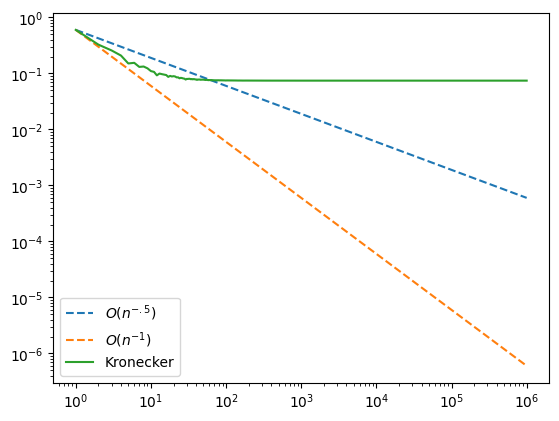

In [2]:
kronecker = qp.Kronecker(dimension=2, alpha=[np.sqrt(2) - 1, np.sqrt(2) - 1])
values = kronecker.periodic_discrepancy(n=int(1e6))

x = np.arange(1, int(1e6) + 1)
y = values[0] / x # multiply by values[0] to get the same starting point
y_half = values[0] / np.sqrt(x)

plt.loglog(x, y_half, label = '$O(n^{-.5})$', linestyle = '--')
plt.loglog(x, y, label = '$O(n^{-1})$', linestyle = '--')
plt.loglog(x, values, label="Kronecker")

plt.legend()
plt.show()

Some examples with random alphas:

[0.5488135  0.71518937]


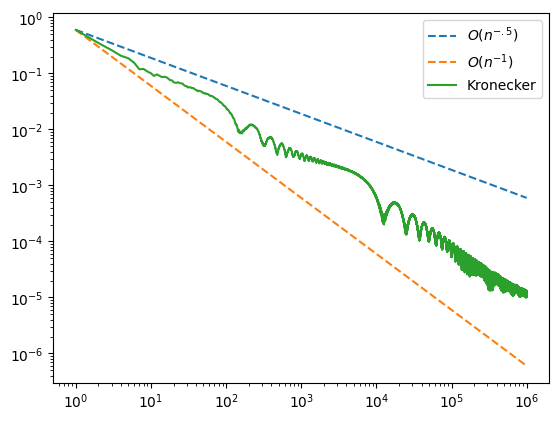

[0.417022   0.72032449]


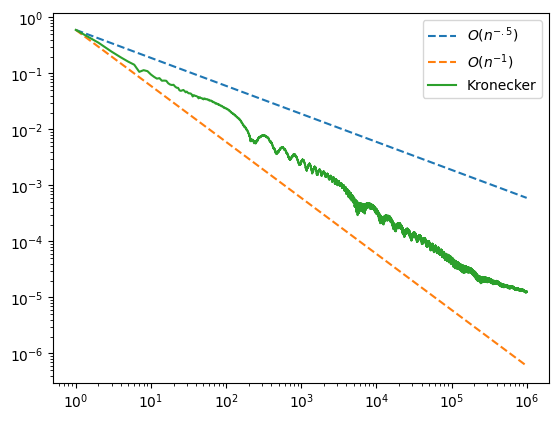

[0.4359949  0.02592623]


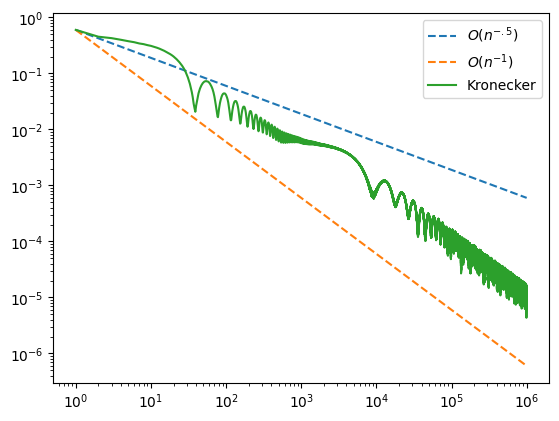

[0.5507979  0.70814782]


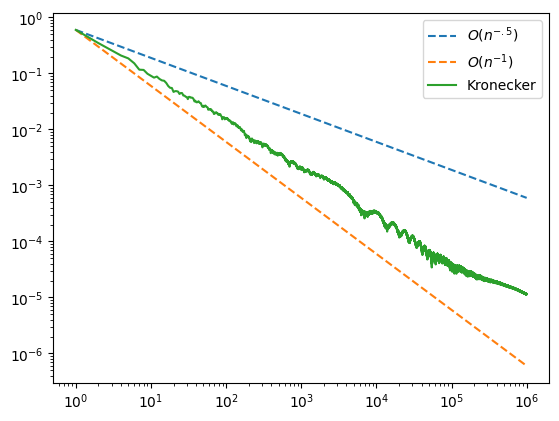

[0.96702984 0.54723225]


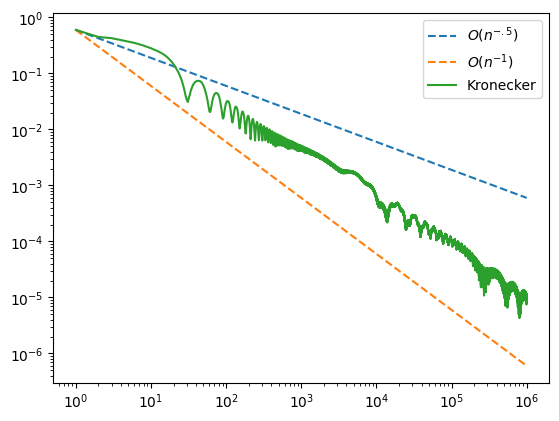

[0.22199317 0.87073231]


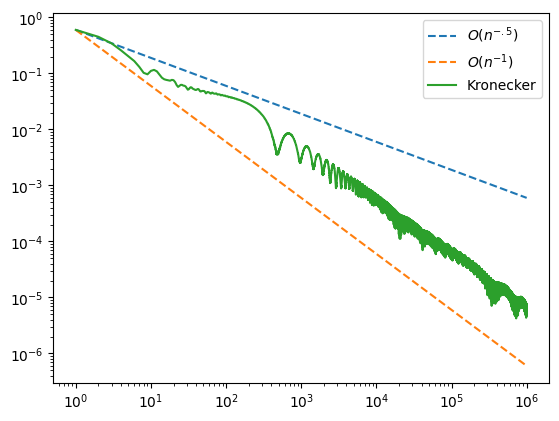

[0.89286015 0.33197981]


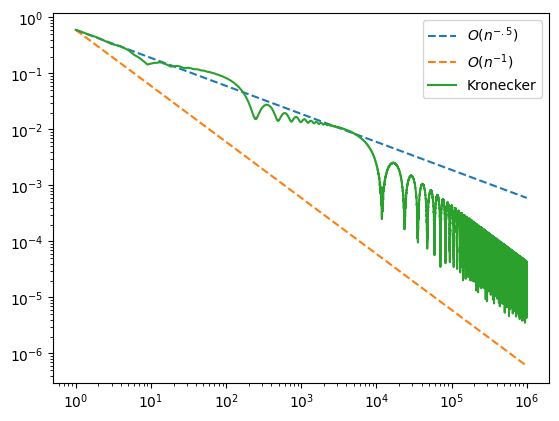

[0.07630829 0.77991879]


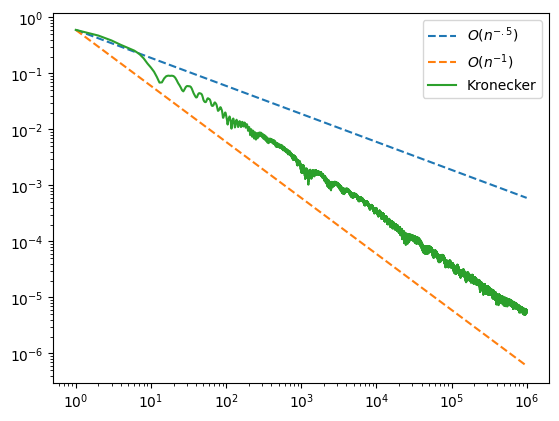

[0.8734294  0.96854066]


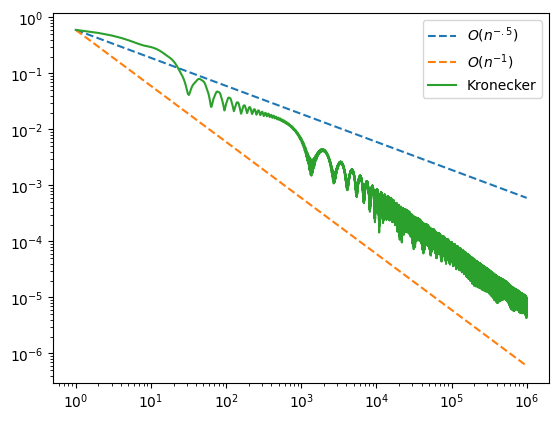

[0.01037415 0.50187459]


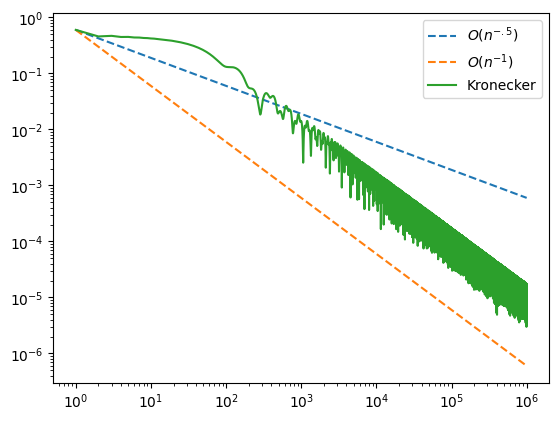

[0.77132064 0.02075195]


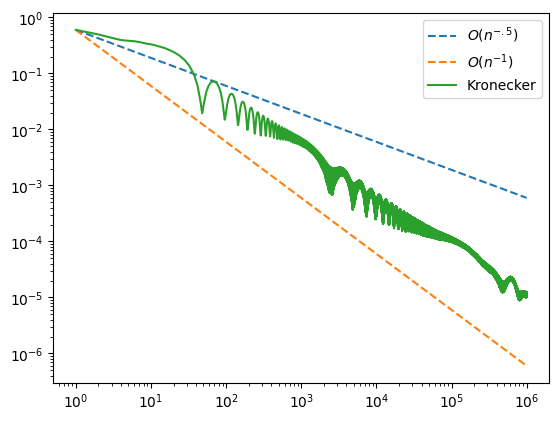

[0.18026969 0.01947524]


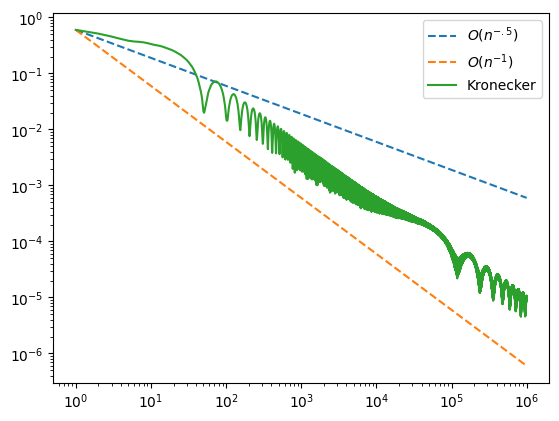

[0.15416284 0.7400497 ]


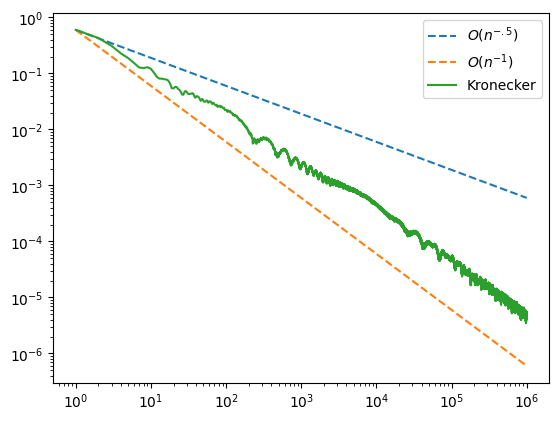

[0.77770241 0.23754122]


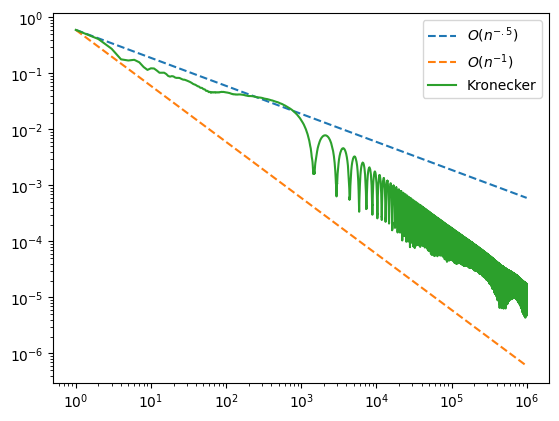

[0.51394334 0.77316505]


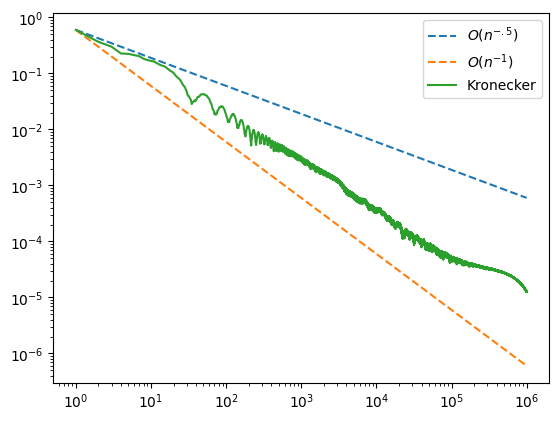

[0.8488177  0.17889592]


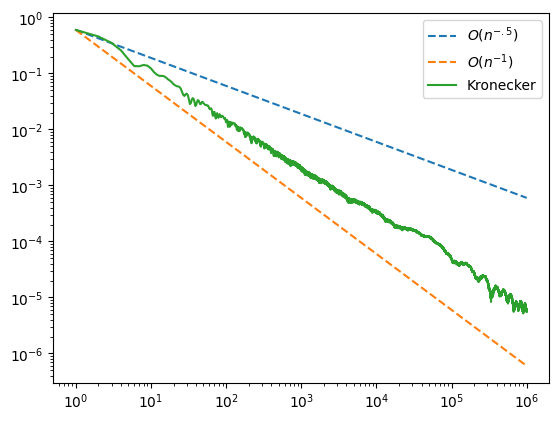

[0.22329108 0.52316334]


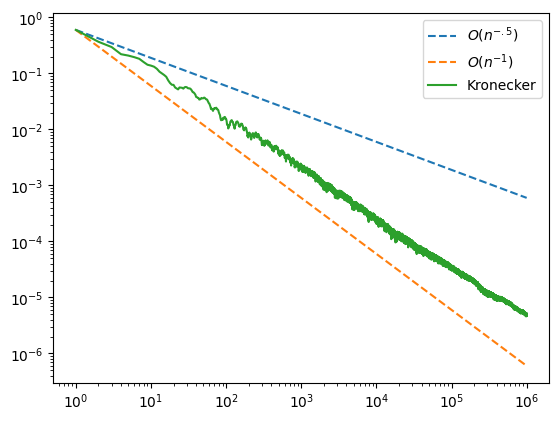

[0.294665   0.53058676]


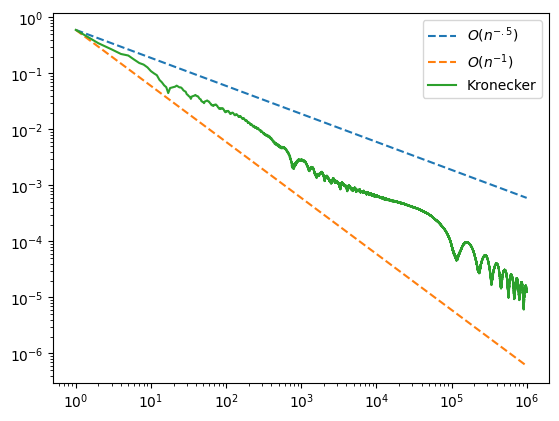

[0.65037424 0.50545337]


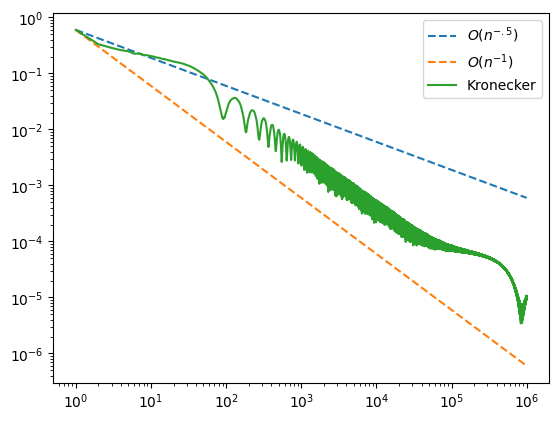

[0.0975336  0.76124972]


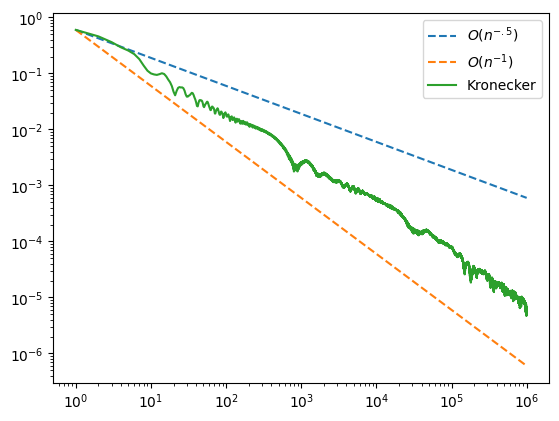

In [3]:
for i in range(20):
    np.random.seed(i)
    random = np.random.rand(2)
    print(random)
    kronecker = qp.Kronecker(dimension=2, alpha=random)
    values = kronecker.periodic_discrepancy(int(1e6))
    
    x = np.arange(1, int(1e6) + 1)
    y = values[0] / x # multiply by values[0] to get the same starting point
    y_half = values[0] / np.sqrt(x)

    plt.loglog(x, y_half, label = '$O(n^{-.5})$', linestyle = '--')
    plt.loglog(x, y, label = '$O(n^{-1})$', linestyle = '--')
    plt.loglog(x, values, label="Kronecker")

    plt.legend()
    plt.show()

In [4]:
# kronecker = qp.Kronecker(dimension=5, alpha=alpha1[:5])
# values = kronecker.periodic_discrepancy(int(1e6), k_tilde, np.ones(5), 1)
# x = np.arange(1, int(1e6) + 1)
# y = values[0] / x
# y_half = values[0] / np.sqrt(x)

# plt.loglog(x, y_half, label = '$O(n^{-.5})$', linestyle = '--')
# plt.loglog(x, y, label = '$O(n^{-1})$', linestyle = '--')
# plt.loglog(x, values, label="Kronecker")

# plt.legend()
# plt.show()

In [5]:
# 20 dimensions, coordiante weights, with alphas

In [6]:
# kronecker = qp.Kronecker(dimension=20, alpha=alpha1)
# values = kronecker.periodic_discrepancy(int(1e6))
# x = np.arange(1, int(1e6) + 1)
# y = values[0] / x
# y_half = values[0] / np.sqrt(x)

# plt.loglog(x, y_half, label = '$O(n^{-.5})$', linestyle = '--')
# plt.loglog(x, y, label = '$O(n^{-1})$', linestyle = '--')
# plt.loglog(x, values, label="Kronecker")

# plt.legend()
# plt.show()

In [7]:
alpha1 = np.random.rand(20)

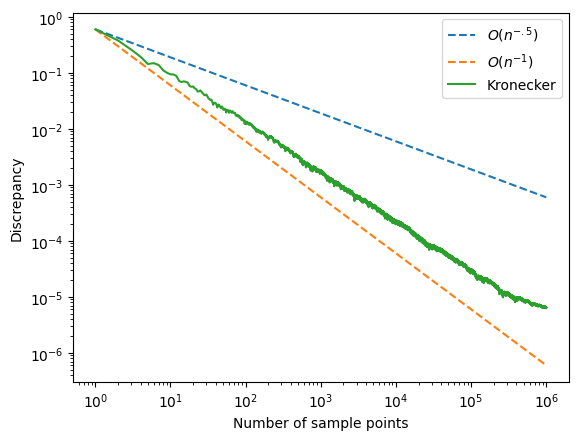

In [8]:
# alpha comes from a call to alpha_generate(2, 1000, 10000) in demos/Kronecker.ipynb
kronecker = qp.Kronecker(dimension=2, alpha=[0.38169895, 0.21603421])
values = kronecker.periodic_discrepancy(int(1e6))
x = np.arange(1, int(1e6) + 1)
y = values[0] / x
y_half = values[0] / np.sqrt(x)

plt.loglog(x, y_half, label = '$O(n^{-.5})$', linestyle = '--')
plt.loglog(x, y, label = '$O(n^{-1})$', linestyle = '--')
plt.loglog(x, values, label="Kronecker")

plt.legend()
plt.xlabel('Number of sample points')
plt.ylabel('Discrepancy')
plt.show()

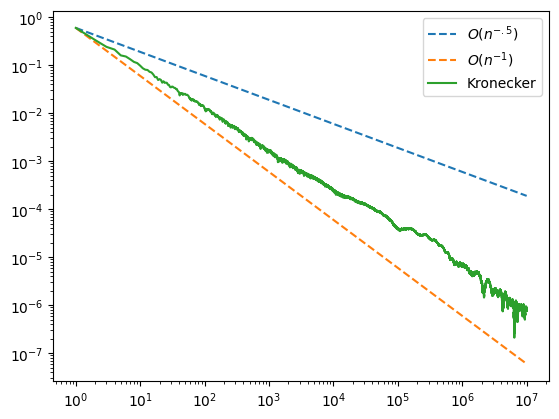

In [9]:
# would calling alpha_generate for 10 dimensions and taking the first two components be good choices for the first two dimensions?
kronecker = qp.Kronecker(dimension=2, alpha=[0.36626695, 0.41351539])
values = kronecker.periodic_discrepancy(int(1e7))
x = np.arange(1, int(1e7) + 1)
y = values[0] / x
y_half = values[0] / np.sqrt(x)

plt.loglog(x, y_half, label = '$O(n^{-.5})$', linestyle = '--')
plt.loglog(x, y, label = '$O(n^{-1})$', linestyle = '--')
plt.loglog(x, values, label="Kronecker")
plt.legend()
plt.show()

### Weighted Sum of Squares of Discrepancy